# Packages

In [33]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from osgeo import gdal
from sklearn import preprocessing

# Functions and constants

In [67]:
def xyz_geotiff(img): # defines a function in where a georeferenced tiff image is inputted and turns it into a grid of data 
    band_r = img.GetRasterBand(1) # retrieves the red layer 
    z_r = np.flipud(band_r.ReadAsArray()) # reads the values from band above and flips them to allow numpy array to read correctly

    band_g = img.GetRasterBand(2) # retrieves the green layer 
    z_g = np.flipud(band_g.ReadAsArray()) 

    band_b = img.GetRasterBand(3) # retrieves the blue layer 
    z_b = np.flipud(band_b.ReadAsArray())

    band_ir = img.GetRasterBand(4) # retrieves the infrared layer 
    z_ir = np.flipud(band_b.ReadAsArray())
    
    width = img.RasterXSize # how big the image is in pixels in the x direction
    height = img.RasterYSize # how big the image is in pixels in the y direction
    
    gt = img.GetGeoTransform() # retrieves the geotransform parameters which provide information about the spatial transformation from pixel coords to geographic coords                                
    # compute the min and max x and y coordinates of the image using geotransform parameters. [] used to extract a value from the array 
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]

    # create linearly spaced arrays of lat and lon values where the length of the array is equal to the width or height of the image
    lon = np.linspace(minx,maxx,width) # list of values between minx and maxx in increments of width 
    lat = np.linspace(miny,maxy,height) # list of values between miny and maxy in increments of height  
    
    return lon,lat,z_r,z_g,z_b,z_ir # returns the lat, lon, and red, green, blue, ir values

In [3]:
def maxmin(array): # function to return the maximum and minimum values in an array 
    max = np.nanmax(array)
    min = np.nanmin(array)
    return max,min

In [31]:
def scale(array):
    #nan_values = np.isnan(array) # checks for nan values in the array
    #array[nan_values] = 0 # replaces the nan values with 0
    
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(array) # scales the array between 0 and 1

    #scaled[nan_values] = np.nan # returns replaced 0 values back a nan value
    
    return scaled

In [59]:
def scalenan(array):
    nan_values = np.isnan(array) # checks for nan values in the array
    array[nan_values] = 0 # replaces the nan values with 0
    
    scaler = preprocessing.MinMaxScaler(feature_range=(0,100))
    scalednan = scaler.fit_transform(array) # scales the array between 0 and 1

    array[nan_values] = np.nan # returns replaced 0 values back a nan value in old array
    scalednan[nan_values] = np.nan # returns replaced 0 values back a nan value in new array
    
    return scalednan

In [63]:
def normalise(array):
    normalise = (array - maxmin(array)[1]) / (maxmin(array)[0] - maxmin(array)[1]) * 100
    return normalise

In [62]:
def gibber(red):
    r = np.copy(red)
    #g = np.copy(green)
    #b = np.copy(blue)

    r[r<170] = np.nan 
    #g[g<190] = np.nan
    #b[b<160] = np.nan

    # result = g_red + g_green + g_blue

# Read Data

In [68]:
# load in the pre-cropped orthomosaic file
data_geotiff = gdal.Open('cropped_20cm_ortho_kalabity.tif') 
lon_geotiff, lat_geotiff, z_r_geotiff, z_g_geotiff, z_b_geotiff, z_ir_geotiff = xyz_geotiff(data_geotiff) # takes each output variable and saves them into variables

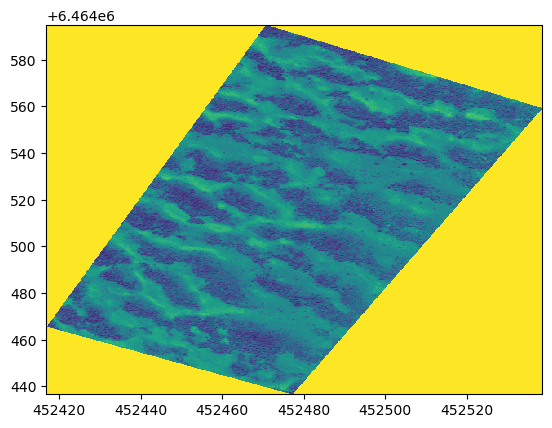

In [70]:
plt.pcolormesh(lon_geotiff, lat_geotiff, z_ir_geotiff)

In [55]:
# converting the arrays to a floating-point type
z_r_geotiff = z_r_geotiff.astype(float) 
z_g_geotiff = z_g_geotiff.astype(float) 
z_b_geotiff = z_b_geotiff.astype(float) 

# assign NaN values to all area around the transect data
z_r_geotiff[z_r_geotiff==255] = np.nan 
z_g_geotiff[z_g_geotiff==255] = np.nan 
z_b_geotiff[z_b_geotiff==255] = np.nan 

In [10]:
maxmin(z_r_geotiff)

(233.0, 17.0)

In [11]:
maxmin(z_g_geotiff)

(214.0, 14.0)

In [12]:
maxmin(z_b_geotiff)

(198.0, 11.0)

# Analysis

In [56]:
# scale each band
scaled_r = scale(z_r_geotiff)
scaled_g = scale(z_g_geotiff)
scaled_b = scale(z_b_geotiff)

C:\Users\idaga\miniconda3\envs\pyigau\Lib\site-packages\sklearn\preprocessing\_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\idaga\miniconda3\envs\pyigau\Lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\idaga\miniconda3\envs\pyigau\Lib\site-packages\sklearn\preprocessing\_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\idaga\miniconda3\envs\pyigau\Lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\idaga\miniconda3\envs\pyigau\Lib\site-packages\sklearn\preprocessing\_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\idaga\miniconda3\envs\pyigau\Lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, 

In [64]:
# https://www.geeksforgeeks.org/how-to-normalize-an-numpy-array-so-the-values-range-exactly-between-0-and-1/

norm = np.sqrt(np.nansum(np.square(z_r_geotiff)))
r_normalized = z_r_geotiff/norm

r_norm2 = (z_r_geotiff-np.nanmin(z_r_geotiff))/(np.nanmax(z_r_geotiff)-np.nanmin(z_r_geotiff)) # normalisation using max min values 

r_scalenan = scalenan(z_r_geotiff)

r_norm3 = normalise(z_r_geotiff)

In [30]:
maxmin(z_r_geotiff)

(233.0, 17.0)

In [29]:
maxmin(r_normalized)

(0.0026151325734326794, 0.00019080366415603239)

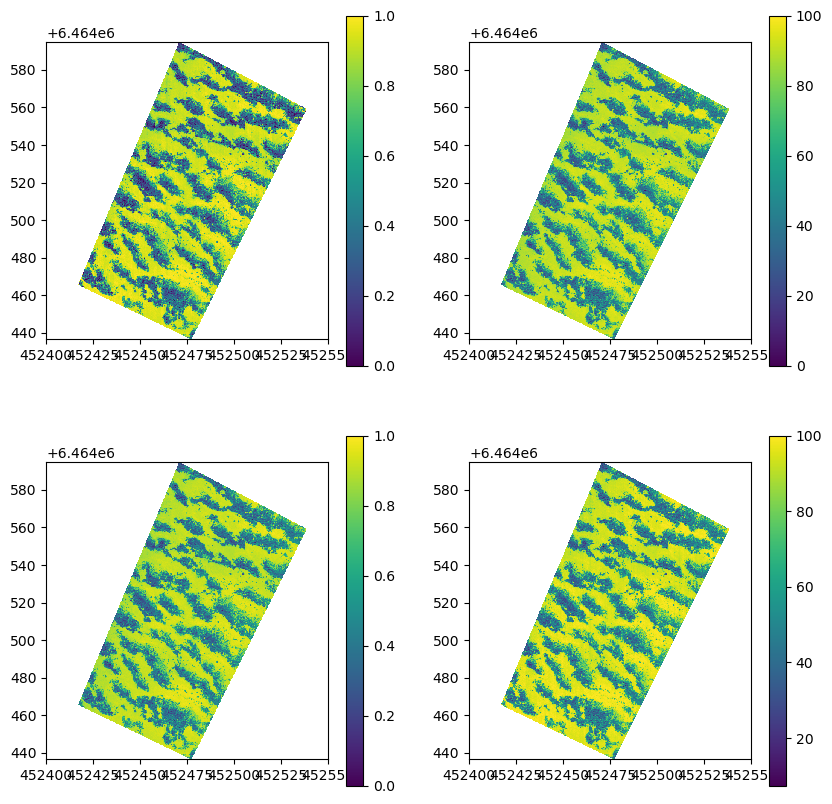

In [65]:
fig = plt.gcf()

plt.subplot(221)
plt.pcolormesh(lon_geotiff,lat_geotiff,scaled_r)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()

plt.subplot(222)
plt.pcolormesh(lon_geotiff,lat_geotiff,r_norm3)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()

plt.subplot(223)
plt.pcolormesh(lon_geotiff,lat_geotiff,r_norm2)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()

plt.subplot(224)
plt.pcolormesh(lon_geotiff,lat_geotiff,r_scalenan) # this one seems to work with scaling values between 0 and 1 and not including those weird artefacts seen in the original scaling plot where nan values weren't dealt with 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()

plt.subplots_adjust(wspace=0.2)
fig.set_size_inches(10,10)

In [15]:
# add all bands together 
add = z_r_geotiff + z_g_geotiff + z_b_geotiff
maxmin(add)

(639.0, 43.0)

In [16]:
# add green and blue
gb = z_g_geotiff + z_b_geotiff
maxmin(gb)

(409.0, 25.0)

In [17]:
# sum gb then subtract sum from red
gbminusr = gb - z_r_geotiff
maxmin(gbminusr)

(180.0, 0.0)

In [18]:
# sum gb then multiply by red
gb_multir = gb * z_r_geotiff
gb_multir[gb_multir==0] = np.nan
maxmin(gb_multir)

(94424.0, 450.0)

In [45]:
scaled_add = scale(add)
scaled_gbminusr = scale(gbminusr)
scaled_gb_multir = scale(gb_multir)
scaled_r = scale(z_r_geotiff)
scaled_g = scale(z_g_geotiff)
scaled_b = scale(z_b_geotiff)

z_r_geotiff[z_r_geotiff==0] = np.nan 
z_g_geotiff[z_g_geotiff==0] = np.nan 
z_b_geotiff[z_b_geotiff==0] = np.nan 

scaled_r[scaled_r==0] = np.nan 
scaled_g[scaled_g==0] = np.nan 
scaled_b[scaled_b==0] = np.nan 

add[add==0] = np.nan 
scaled_add[scaled_add==0] = np.nan

gbminusr[gbminusr==0] = np.nan
scaled_gbminusr[scaled_gbminusr==0] = np.nan

gb_multir[gb_multir==0] = np.nan
scaled_gb_multir[scaled_gb_multir==0] = np.nan

In [167]:
r = np.copy(z_r_geotiff)
r[r<170] = np.nan

g = np.copy(z_g_geotiff)
g[g<170] = np.nan 

b = np.copy(z_b_geotiff)
b[b<170] = np.nan 

In [177]:
maxmin(r)

C:\Users\idaga\AppData\Local\Temp\ipykernel_12456\287536152.py:2: RuntimeWarning: All-NaN slice encountered
  max = np.nanmax(array)
C:\Users\idaga\AppData\Local\Temp\ipykernel_12456\287536152.py:3: RuntimeWarning: All-NaN slice encountered
  min = np.nanmin(array)


(nan, nan)

In [168]:
np.shape(g)

(791, 608)

In [169]:
np.shape(b)

(791, 608)

# Plots

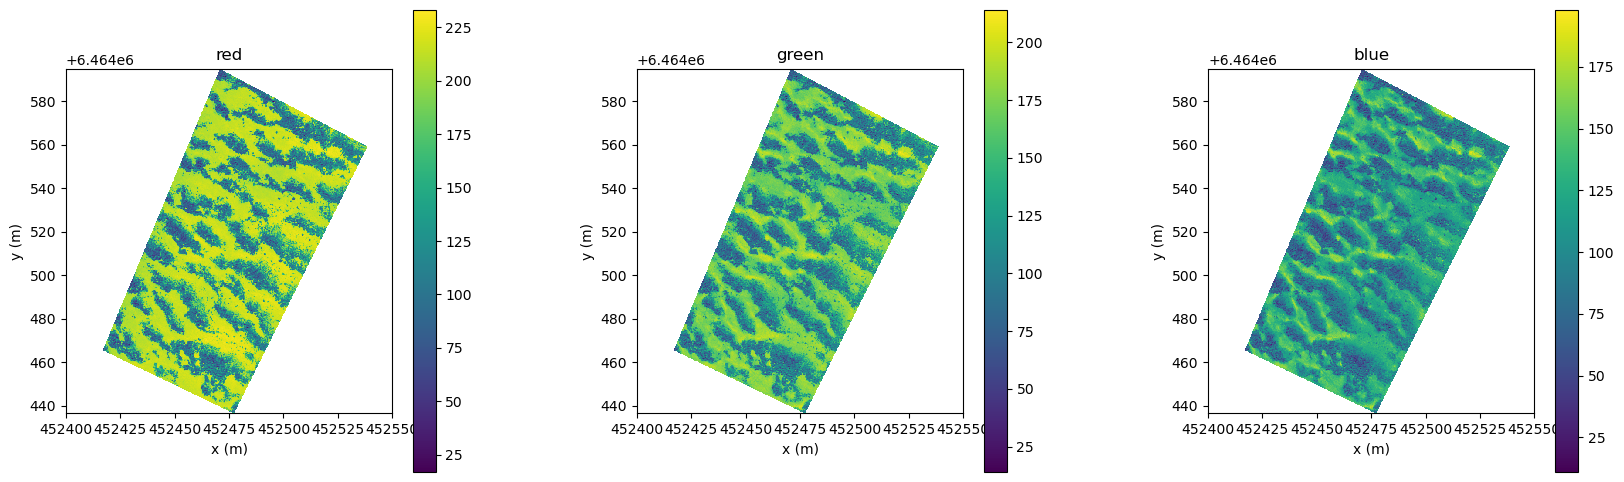

In [48]:
# initial plots of each colour band
fig = plt.gcf()

plt.subplot(131)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_r_geotiff) 
plt.axis('square')
plt.xlim(452400,452550)
#plt.xticks(rotation=30)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('red')

plt.subplot(132)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_g_geotiff) 
plt.axis('square')
plt.xlim(452400,452550)
#plt.xticks(rotation=30)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('green')

plt.subplot(133)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_b_geotiff) 
plt.axis('square')
plt.xlim(452400,452550)
#plt.xticks(rotation=30)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('blue')

plt.subplots_adjust(wspace=0.4)
fig.set_size_inches(20,6)

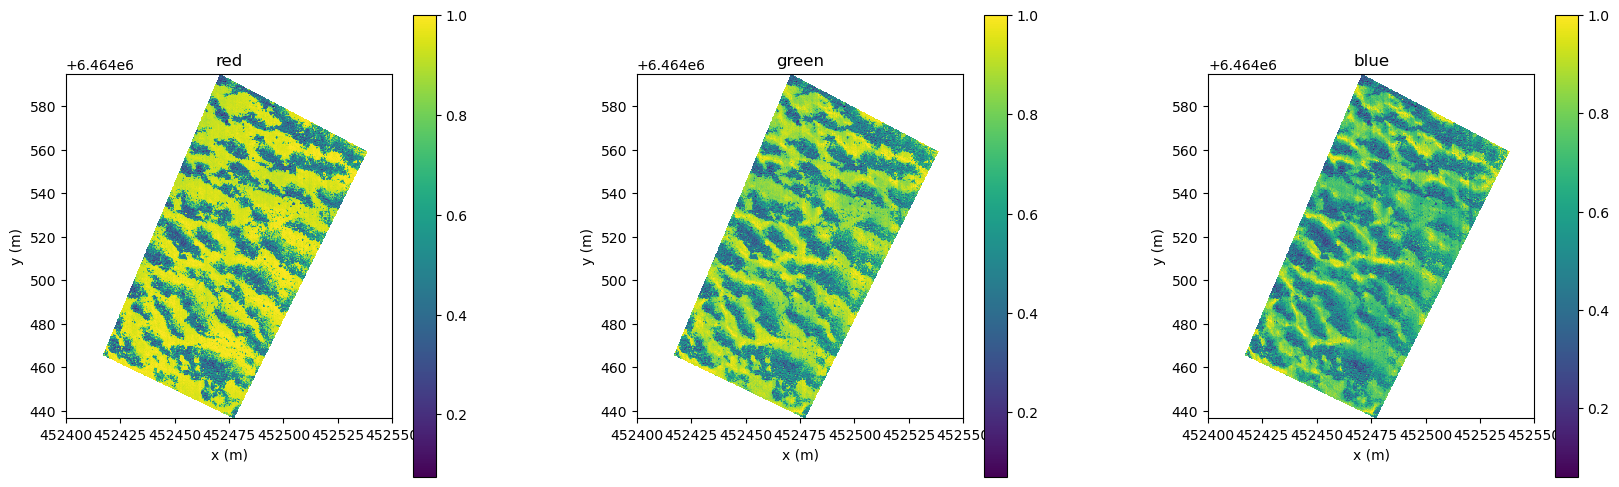

In [49]:
# scaled plots of each colour band
fig = plt.gcf()

plt.subplot(131)
plt.pcolormesh(lon_geotiff,lat_geotiff,scaled_r) 
plt.axis('square')
plt.xlim(452400,452550)
#plt.xticks(rotation=30)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('red')

plt.subplot(132)
plt.pcolormesh(lon_geotiff,lat_geotiff,scaled_g) 
plt.axis('square')
plt.xlim(452400,452550)
#plt.xticks(rotation=30)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('green')

plt.subplot(133)
plt.pcolormesh(lon_geotiff,lat_geotiff,scaled_b) 
plt.axis('square')
plt.xlim(452400,452550)
#plt.xticks(rotation=30)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('blue')

plt.subplots_adjust(wspace=0.4)
fig.set_size_inches(20,6)

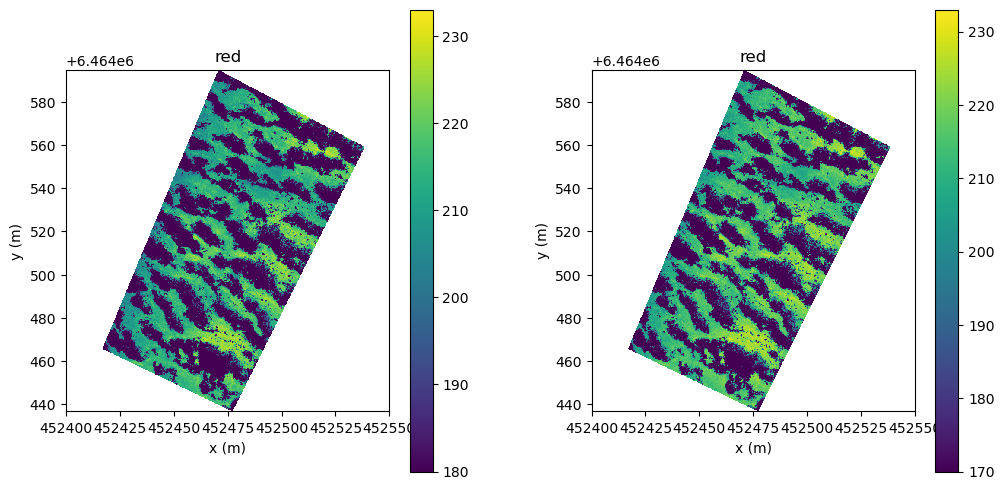

In [50]:
# red band analysis
fig = plt.gcf()

plt.subplot(121)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_r_geotiff, vmin=180, vmax=233) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('red')

plt.subplot(122)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_r_geotiff, vmin=170, vmax=233) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('red')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(12,6)

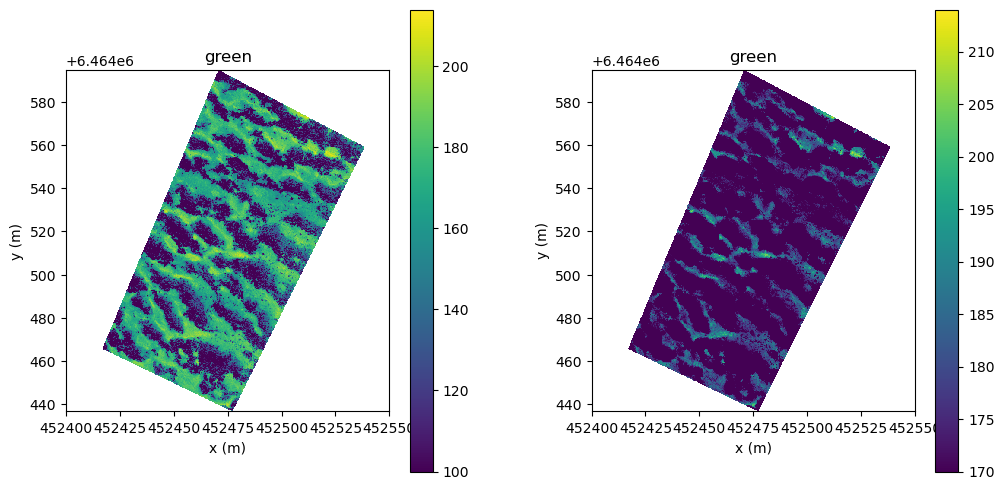

In [51]:
# green band analysis
fig = plt.gcf()

plt.subplot(121)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_g_geotiff, vmin=100, vmax=214) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('green')

plt.subplot(122)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_g_geotiff, vmin=170, vmax=214) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('green')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(12,6)

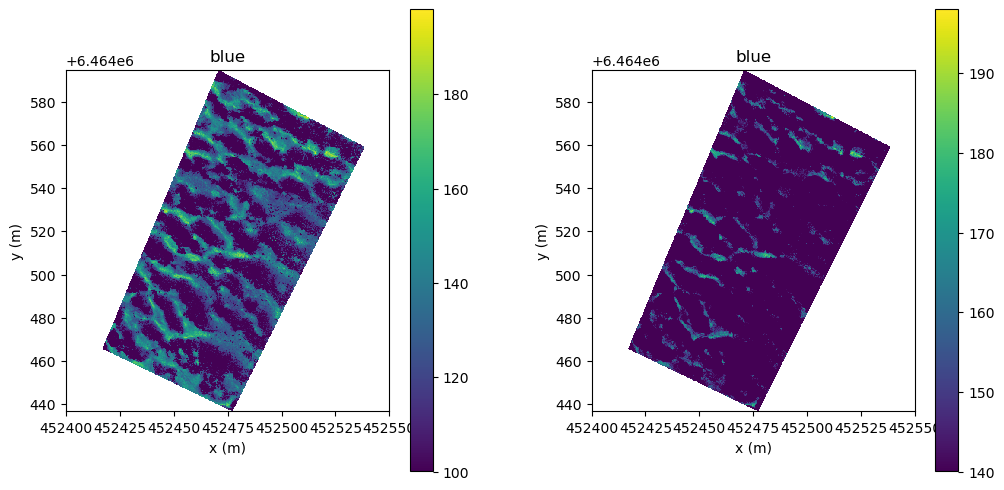

In [52]:
# blue band analysis
fig = plt.gcf()

plt.subplot(121)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_b_geotiff, vmin=100, vmax=198) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('blue')

plt.subplot(122)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_b_geotiff, vmin=140, vmax=198) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('blue')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(12,6)

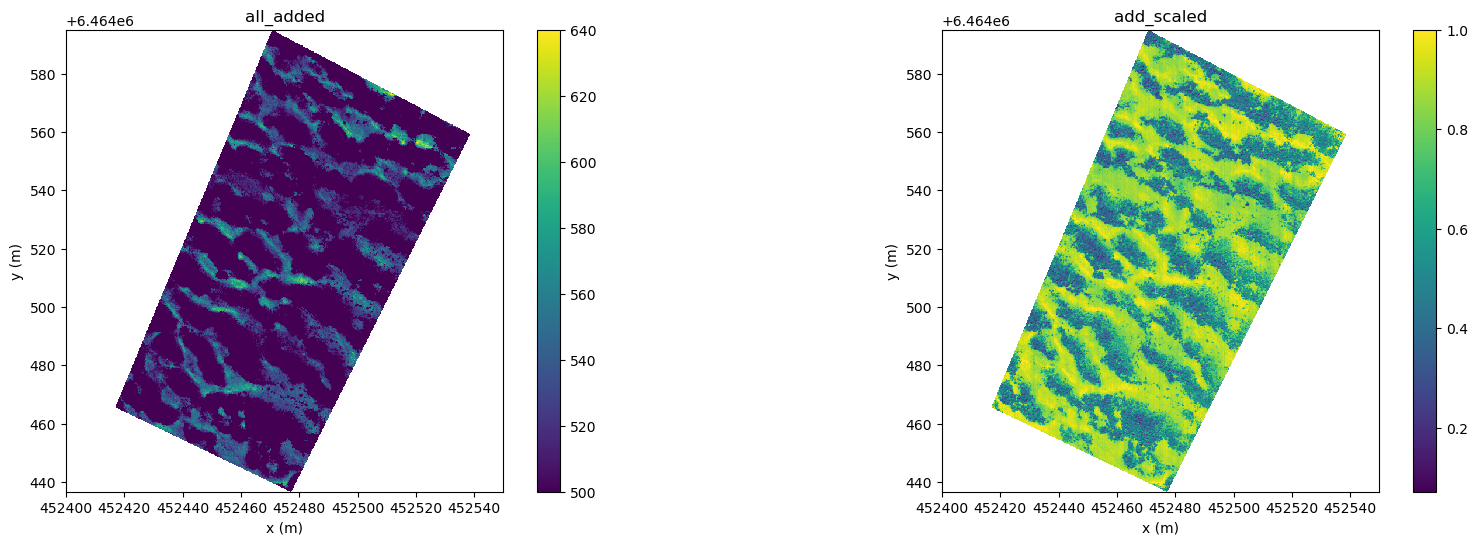

In [53]:
# plot of all bands added together 
fig = plt.gcf()

plt.subplot(121)
plt.pcolormesh(lon_geotiff,lat_geotiff,add, vmin=500, vmax=640) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('all_added')

plt.subplot(122)
plt.pcolormesh(lon_geotiff,lat_geotiff,scaled_add) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('add_scaled')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(20,6)

# strong correlation between higher values of z with gibber coverage

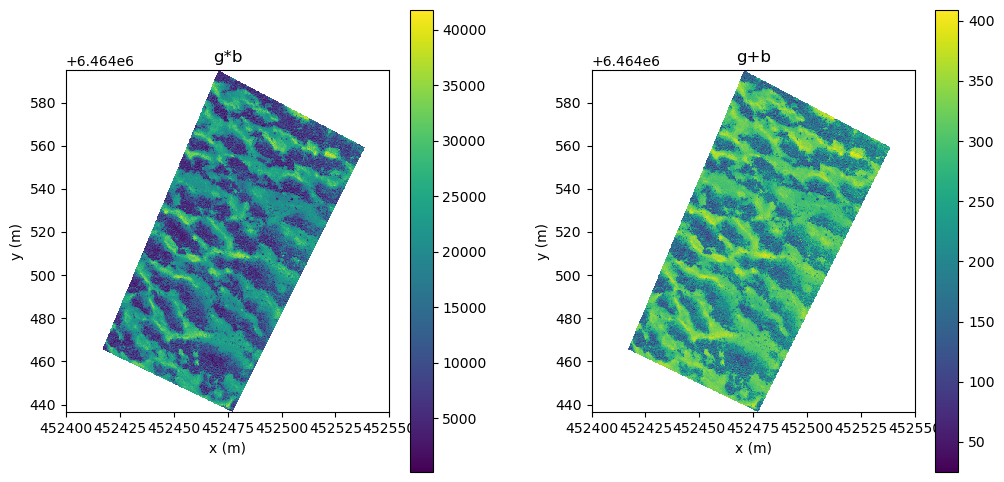

In [54]:
# plot of g + b
fig = plt.gcf()

plt.subplot(121)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_g_geotiff*z_b_geotiff) #, vmin=500, vmax=640 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('g*b')

plt.subplot(122)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_g_geotiff+z_b_geotiff) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('g+b')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(12,6)

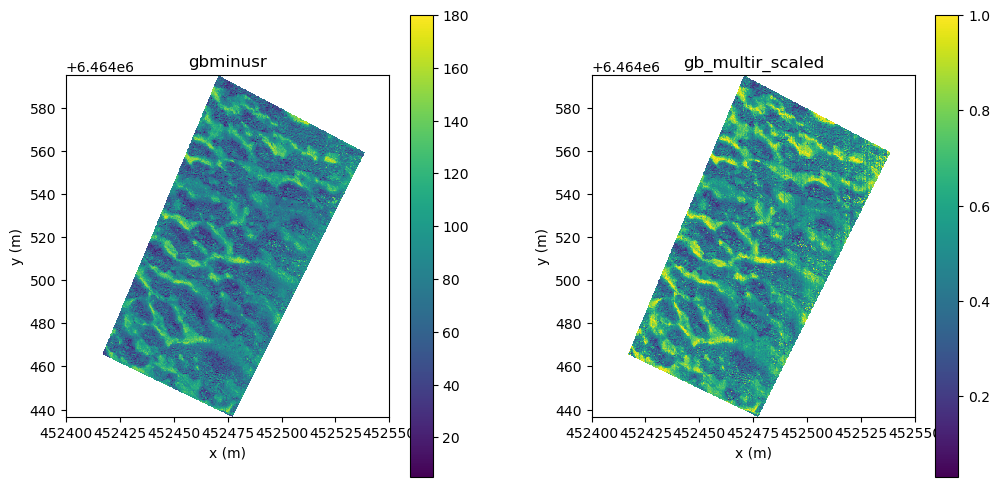

In [55]:
# plot of (green + blue) - red  
fig = plt.gcf()

plt.subplot(121)
plt.pcolormesh(lon_geotiff,lat_geotiff,gbminusr) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('gbminusr')

plt.subplot(122)
plt.pcolormesh(lon_geotiff,lat_geotiff,scaled_gbminusr) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('gb_multir_scaled')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(12,6)

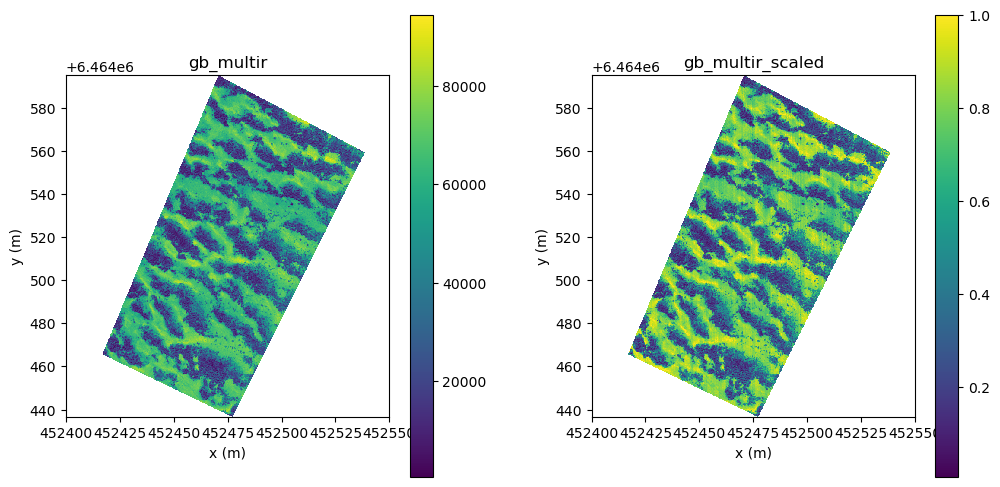

In [56]:
# plot of (green + blue) * red  
fig = plt.gcf()

plt.subplot(121)
plt.pcolormesh(lon_geotiff,lat_geotiff,gb_multir) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('gb_multir')

plt.subplot(122)
plt.pcolormesh(lon_geotiff,lat_geotiff,scaled_gb_multir) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('gb_multir_scaled')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(12,6)

# Second Attempt

In [9]:
rpercent = z_r_geotiff/255
gpercent = z_g_geotiff/255
bpercent = z_b_geotiff/255

# step through each raster grid and see if eg. green values is bigger than blue value. define as something if that is true

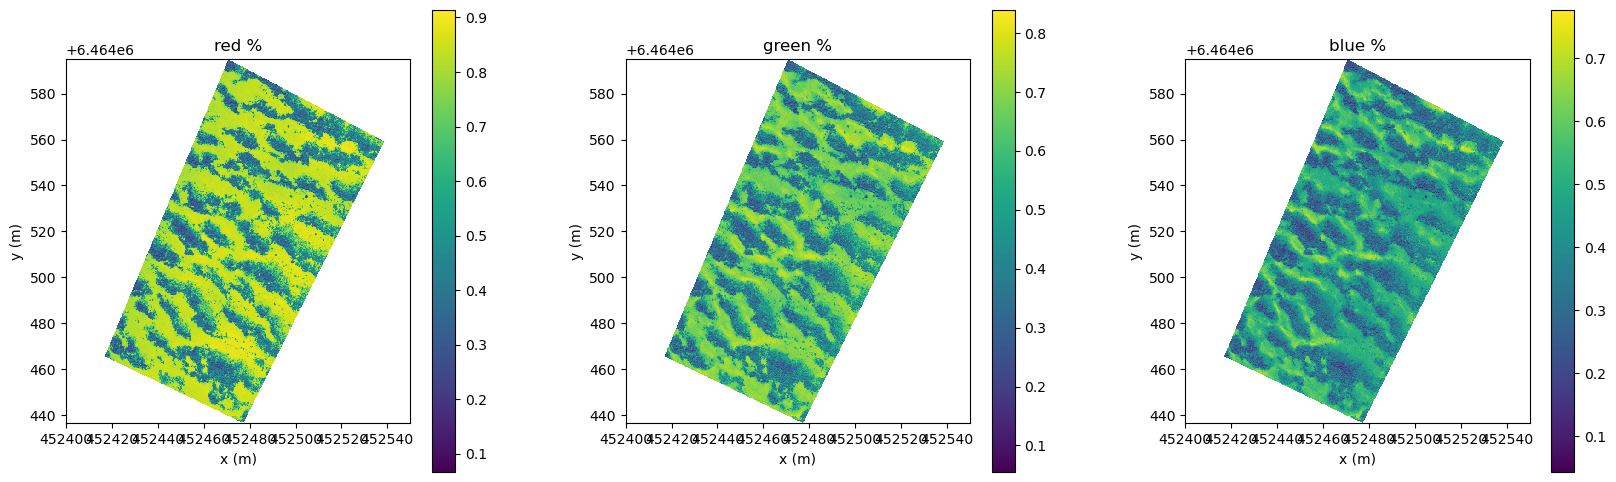

In [95]:
# plots of the percentage of the total colour for each band ie. values in array / by 255
fig = plt.gcf()

plt.subplot(131)
plt.pcolormesh(lon_geotiff,lat_geotiff,rpercent) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('red %')

plt.subplot(132)
plt.pcolormesh(lon_geotiff,lat_geotiff,gpercent) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('green %')

plt.subplot(133)
plt.pcolormesh(lon_geotiff,lat_geotiff,bpercent) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('blue %')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(20,6)

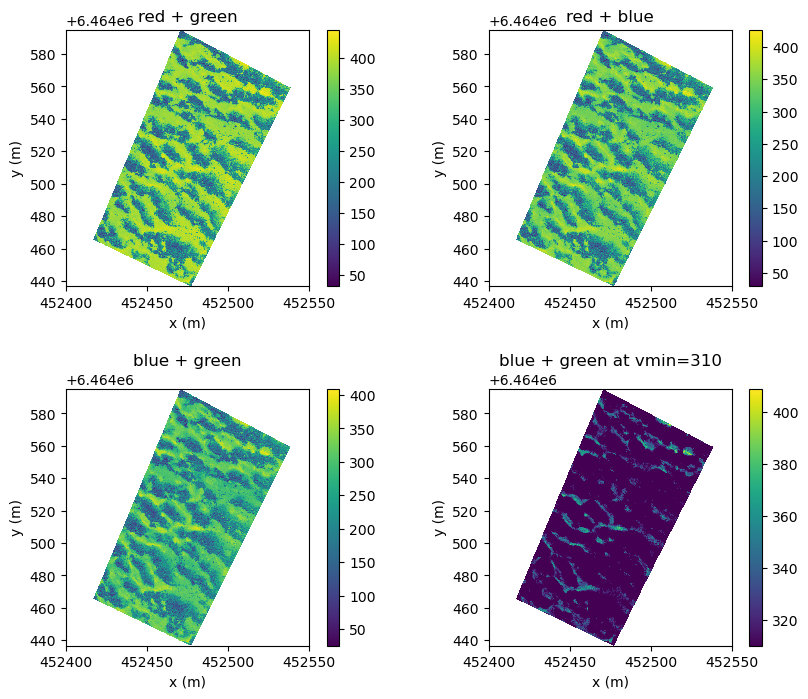

In [109]:
# plot of all bands added together 
fig = plt.gcf()

plt.subplot(221)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_r_geotiff+z_g_geotiff) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('red + green')

plt.subplot(222)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_r_geotiff+z_b_geotiff) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('red + blue')

plt.subplot(223)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_b_geotiff+z_g_geotiff) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('blue + green')

plt.subplot(224)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_b_geotiff+z_g_geotiff, vmin=310) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('blue + green at vmin=310')

plt.subplots_adjust(hspace=0.4)
fig.set_size_inches(10,8)

# realised that the red band wasn't differentiating between bare ground surface and gibber so focused on blue and green
# manually found the threshold for vmin that matched the gibber cover in the high res photo which was 310

In [94]:
bg = z_b_geotiff+z_g_geotiff # isolated the blue + green bands and saved in a separate variable

# change all values aside from those above 310 to nan
bg[(bg > 0) & (bg < 310)] = np.nan 
bg_gib = bg[bg >= 310]
bg[bg < 0] = np.nan

scale_bg = scale(bg)*100 # then scale the remaining values and convert to %

In [87]:
maxmin(bg) # checking the maximum and minimum values of bg

(409.0, 0.0)

Text(0, 0.5, 'Latitude (m)')

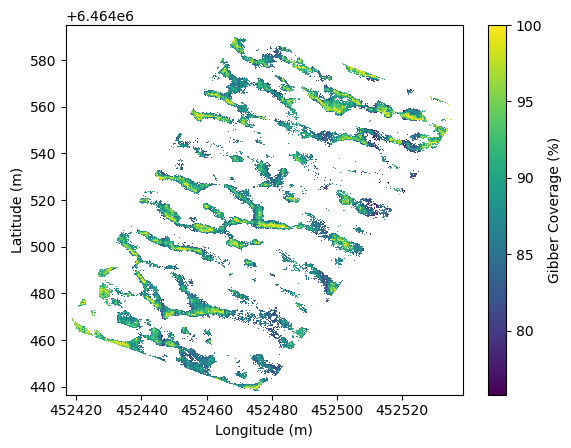

In [114]:
plt.pcolormesh(lon_geotiff, lat_geotiff, scale_bg)
plt.colorbar(label = 'Gibber Coverage (%)')
plt.xlabel('Longitude (m)')
plt.ylabel('Latitude (m)')